In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')

df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [3]:
df.shape

(617, 58)

<Axes: ylabel='Class'>

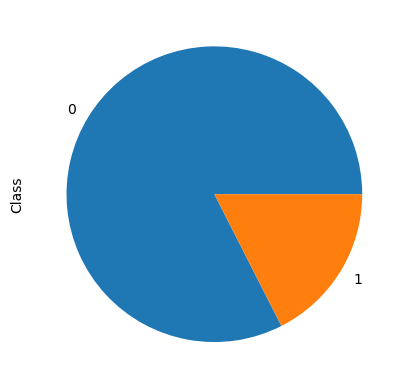

In [4]:
plot_df = df.Class.value_counts()
plot_df.plot(kind="pie")

In [5]:
# Store all the numerical column names into a list
NUM_FEATURE_COLUMNS = [i for i in df.columns if i not in ["Id", "EJ", "Class"]]

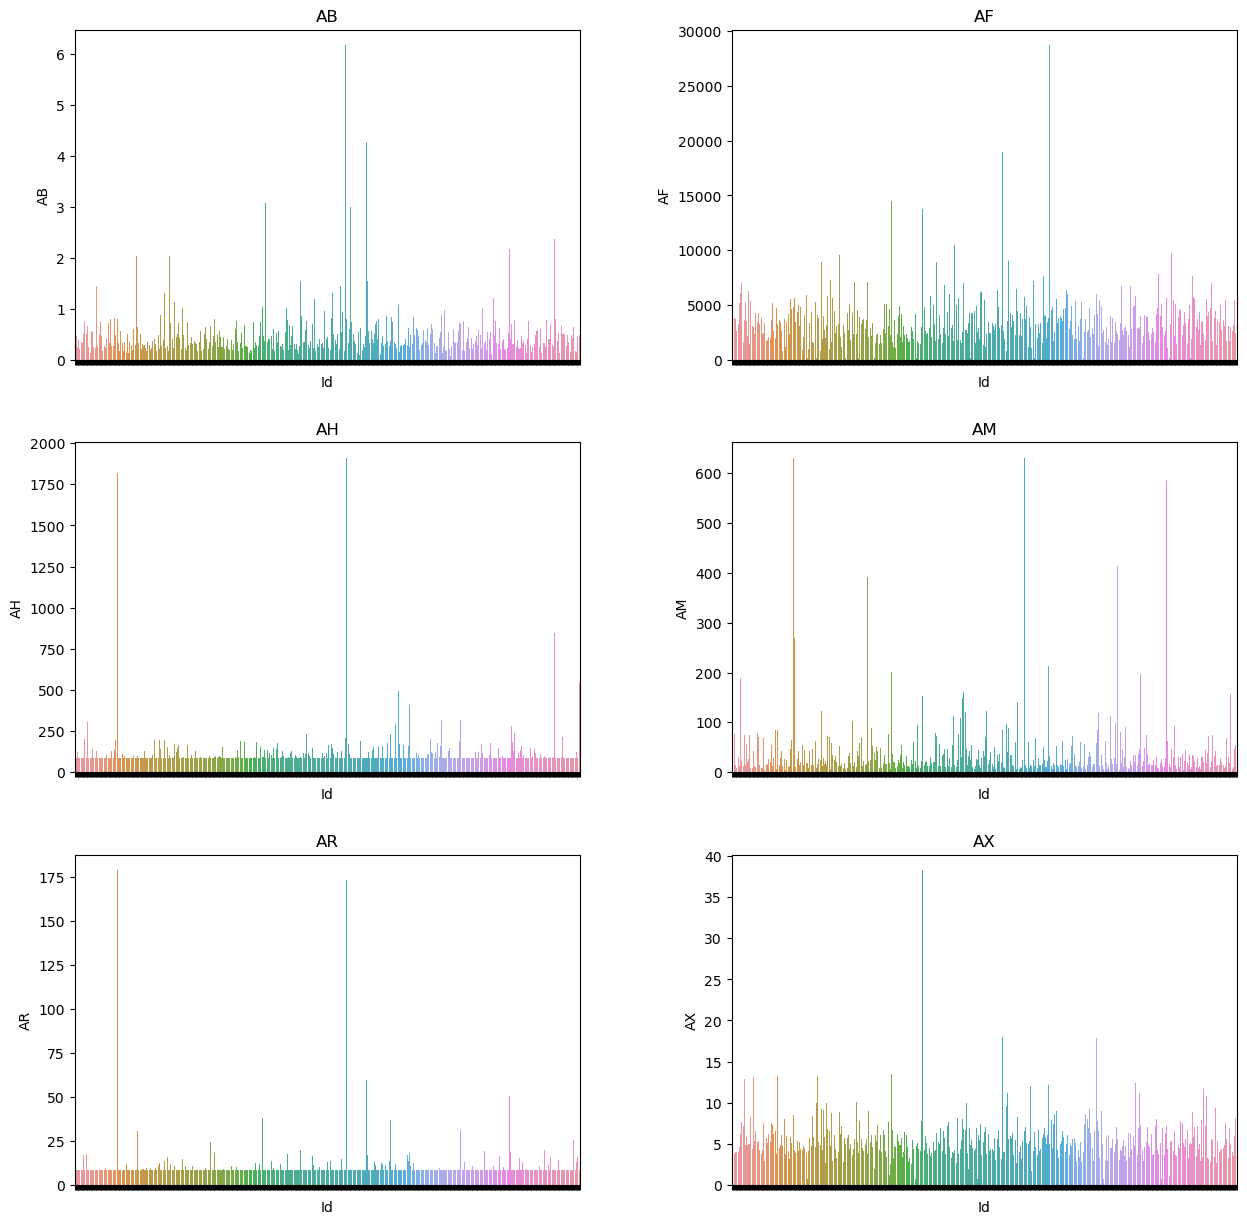

In [6]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=df['Id'], y=df[column_name])
    bp.set(xticklabels=[])
    #bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title(column_name)
plt.show()

In [7]:
FEATURE_COLUMNS = [i for i in df.columns if i not in ["Id"]]

KFold validation
used for training model because normal train/test split training won't be enough

In [8]:
# Creates a GroupKFold with 5 splits
kf = KFold(n_splits=5)

Out of Fold (OOF) used for the predictions made on the test set of each fold

In [9]:
# Create list of ids for the creation of oof dataframe
ID_LIST = df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

### Select a model

In [10]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [11]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpgzxq6i_8 as temporary training directory


### Hyperparameter tuning to avoid overfitting

In [12]:
rf = tfdf.keras.RandomForestModel(max_depth=5, num_trees=500)

Use /tmp/tmpzymu9kqk as temporary training directory


### Handle dataset imbalance

In [13]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(df['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



#### 1. Undersampling
Under-sample the majority class by choosing smaller subset of majority class

In [14]:
# This function generates undersampled dataset.
def random_under_sampler(df):
    # Calculate the number of samples for each label. 
    neg, pos = np.bincount(df['Class'])

    # Choose the samples with class label `1`.
    one_df = df.loc[df['Class'] == 1] 
    # Choose the samples with class label `0`.
    zero_df = df.loc[df['Class'] == 0]
    # Select `pos` number of negative samples.
    # This makes sure that we have equal number of samples for each label.
    zero_df = zero_df.sample(n=pos)

    # Join both label dataframes.
    undersampled_df = pd.concat([zero_df, one_df])

    # Shuffle the data and return
    return undersampled_df.sample(frac = 1)

#### 2. Class weighting
Pay more attention to examples from minority class

In [15]:
# Calculate the number of samples for each label
neg, pos = np.bincount(df['Class'])

# Calculate total samples
total = neg + pos

# Calculate the weight for each label
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1:weight_for_1}

print('Weight for class 0: {:.2f}' .format(weight_for_0))
print('Weight for class 1: {:.2f}' .format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


### Train the model 

In [16]:
# Loop through each fold
for i, (train_index, valid_index) in enumerate(kf.split(X=df)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = df.iloc[train_index]
        valid_df = df.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        train_df = train_df[FEATURE_COLUMNS]
        valid_df = valid_df[FEATURE_COLUMNS]
        
        # There's one more step required before we can train the model. 
        # We need to convert the datatset from Pandas format (pd.DataFrame)
        # into TensorFlow Datasets format (tf.data.Dataset).
        # TensorFlow Datasets is a high performance data loading library 
        # which is helpful when training neural networks with accelerators like GPUs and TPUs.
        # Note: Some column names contains white spaces at the end of their name, 
        # which is non-comaptible with SavedModels save format. 
        # By default, `pd_dataframe_to_tf_dataset` function will convert 
        # this column names into a compatible format. 
        # So you can safely ignore the warnings related to this.
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
        rf = tfdf.keras.RandomForestModel()
        rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
        
        # Train the model
        # We will train the model using a one-liner.
        # Note: you may see a warning about Autograph. 
        # You can safely ignore this, it will be fixed in the next release.
        # Previously calculated class weights is used to handle imbalance.
        rf.fit(x=train_ds, class_weight=class_weight)
        
        # Store the model
        models[f"fold_{i+1}"] = rf
        
        
        # Predict OOF value for validation data
        predict = rf.predict(x=valid_ds)
        
        # Store the predictions in oof dataframe
        oof.loc[valid_ids, 0] = predict.flatten() 
        
        # Evaluate and store the metrics in respective dicts
        evaluation = rf.evaluate(x=valid_ds,return_dict=True)
        accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
        cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

##### Fold 1
Use /tmp/tmp7opz7w0n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:08.470918. Found 493 examples.
Training model...
Model trained in 0:00:00.383985
Compiling model...


[INFO 23-07-16 09:24:11.0217 UTC kernel.cc:1243] Loading model from path /tmp/tmp7opz7w0n/model/ with prefix 5885d0efec104f84
[INFO 23-07-16 09:24:11.0842 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14268 node(s), and 56 input feature(s).
[INFO 23-07-16 09:24:11.0844 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-16 09:24:11.0846 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 1s 822ms/step - loss: 0.0000e+00 - accuracy: 0.9516 - binary_crossentropy: 0.2182
##### Fold 2
Use /tmp/tmp3xix1b0s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.165042. Found 493 examples.
Training model...
Model trained in 0:00:00.312207
Compiling model...


[INFO 23-07-16 09:24:17.4828 UTC kernel.cc:1243] Loading model from path /tmp/tmp3xix1b0s/model/ with prefix 87c1bc55dccc45d5
[INFO 23-07-16 09:24:17.5388 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13582 node(s), and 56 input feature(s).
[INFO 23-07-16 09:24:17.5391 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 393ms/step - loss: 0.0000e+00 - accuracy: 0.8790 - binary_crossentropy: 0.2608
##### Fold 3
Use /tmp/tmpus4gskvf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.747183. Found 494 examples.
Training model...
Model trained in 0:00:00.317229
Compiling model...


[INFO 23-07-16 09:24:20.9771 UTC kernel.cc:1243] Loading model from path /tmp/tmpus4gskvf/model/ with prefix 8166cc1d84da49cb
[INFO 23-07-16 09:24:21.0379 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13376 node(s), and 56 input feature(s).
[INFO 23-07-16 09:24:21.0383 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 448ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2741
##### Fold 4
Use /tmp/tmpc17onw9z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.118406. Found 494 examples.
Training model...
Model trained in 0:00:00.306275
Compiling model...


[INFO 23-07-16 09:24:23.8797 UTC kernel.cc:1243] Loading model from path /tmp/tmpc17onw9z/model/ with prefix b9b29910d08b44bb
[INFO 23-07-16 09:24:23.9371 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13434 node(s), and 56 input feature(s).
[INFO 23-07-16 09:24:23.9372 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-16 09:24:23.9373 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 456ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2717
##### Fold 5
Use /tmp/tmpn0qpd5aa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.072280. Found 494 examples.
Training model...
Model trained in 0:00:00.313096
Compiling model...


[INFO 23-07-16 09:24:26.7885 UTC kernel.cc:1243] Loading model from path /tmp/tmpn0qpd5aa/model/ with prefix 2827132b352a44a2
[INFO 23-07-16 09:24:26.8466 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13980 node(s), and 56 input feature(s).
[INFO 23-07-16 09:24:26.8466 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 403ms/step - loss: 0.0000e+00 - accuracy: 0.9512 - binary_crossentropy: 0.2172


### Visualize the model

In [17]:
tfdf.model_plotter.plot_model_in_colab(models['fold_1'], tree_idx=0, max_depth=3)

In [18]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9516 loss: 0.2182
fold_2: acc: 0.8790 loss: 0.2608
fold_3: acc: 0.9024 loss: 0.2741
fold_4: acc: 0.9024 loss: 0.2717
fold_5: acc: 0.9512 loss: 0.2172

Average accuracy: 0.9173  Average loss: 0.2484


### Submission

In [19]:
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
test_ds_pd = test_df
test_df_columns = test_ds_pd.columns.tolist()
TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
                        if i in test_df_columns and i != "Class"]
test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd)
predictions = models['fold_1'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)

1/1 [==============================] - 0s 142ms/step
[[0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643]]


In [20]:
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)